<a href="https://colab.research.google.com/github/danielepiano/AN2DL-First-Challenge-Ibuprofen/blob/main/Luca_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:

import os
from datetime import datetime

import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import logging
import random
import numpy as np

In [5]:
from google.colab import drive

drive.mount("/gdrive")
working_dir = "/gdrive/My Drive/B University/Artificial Networks/an2dl2526c1"
input_dir = working_dir

%cd $working_dir

# print(f"Working at folder: {working_dir}")
# print(f"Input at folder: {input_dir}")

dataset_name = "an2dl2526c1"
dataset_dir = f"{input_dir}"

# Check if data directory exists
if not os.path.exists(dataset_dir):
    print(f"Error: Dataset folder not found for '{dataset_name}' at expected input path: {input_dir}")
# Load data
else:
  # print(f"Dataset folder found for '{dataset_name}': {dataset_dir}")

  try:
      df_features_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train.csv')
      df_labels_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_train_labels.csv')
      df_test_raw = pd.read_csv(f'{dataset_dir}/pirate_pain_test.csv')
  except FileNotFoundError as e:
        print(f"Error: CSV file {e.filename} not found at expected data path: {dataset_dir}")
  print(f"Dataset '{dataset_name}' loaded successfully")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/B University/Artificial Networks/an2dl2526c1
Dataset 'an2dl2526c1' loaded successfully




**________Check dimentions**:   

Each samples_index has been tracked for the same number of time steps: this simplifies sequence management.

time-steps : 160 , number of series:  661

Features shape: (rows: 105760, columns: 40)

Labels shape: (rows: 661, columns: 2)




**________Distribution of labels (train labels)**:

no_pain      511

low_pain      94

high_pain     56

In [7]:
# Utility definitions
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
body_parts_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [f'joint_{i:02d}' for i in range(31)] # joint_00 to joint_30

# Define numeric features
numeric_cols = joint_cols

# Display summary for numeric features
print("\nDescriptive statistics summary (numeric features):")
numeric_stats = df_features_raw[numeric_cols].describe()
display(numeric_stats)


Descriptive statistics summary (numeric features):


,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,0.943095,0.916955,0.779296,0.767921,0.709186,0.711306,0.875185,0.837427,0.849700,0.909554,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,0.202051,0.197608,0.295605,0.300787,0.418058,0.411783,0.240900,0.237904,0.180489,0.180320,...,4.974496e-03,5.472244e-03,1.235450e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.0
min,0.000000,0.000000,0.001015,0.005403,0.000000,0.000000,0.000000,0.000000,0.122095,0.004671,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,0.828277,0.811445,0.568850,0.520020,0.184585,0.210551,0.839166,0.781375,0.717725,0.825898,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,1.005126,0.979468,0.909549,0.914834,0.930007,0.950628,0.937363,0.904914,0.831221,0.940954,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746147e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,1.081039,1.056611,0.995187,0.994324,1.036497,1.032400,1.013150,0.984410,0.991104,1.030941,...,2.800090e-06,3.079465e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,1.407968,1.334613,1.306046,1.254729,1.359204,1.387731,1.410532,1.361969,1.357288,1.388105,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


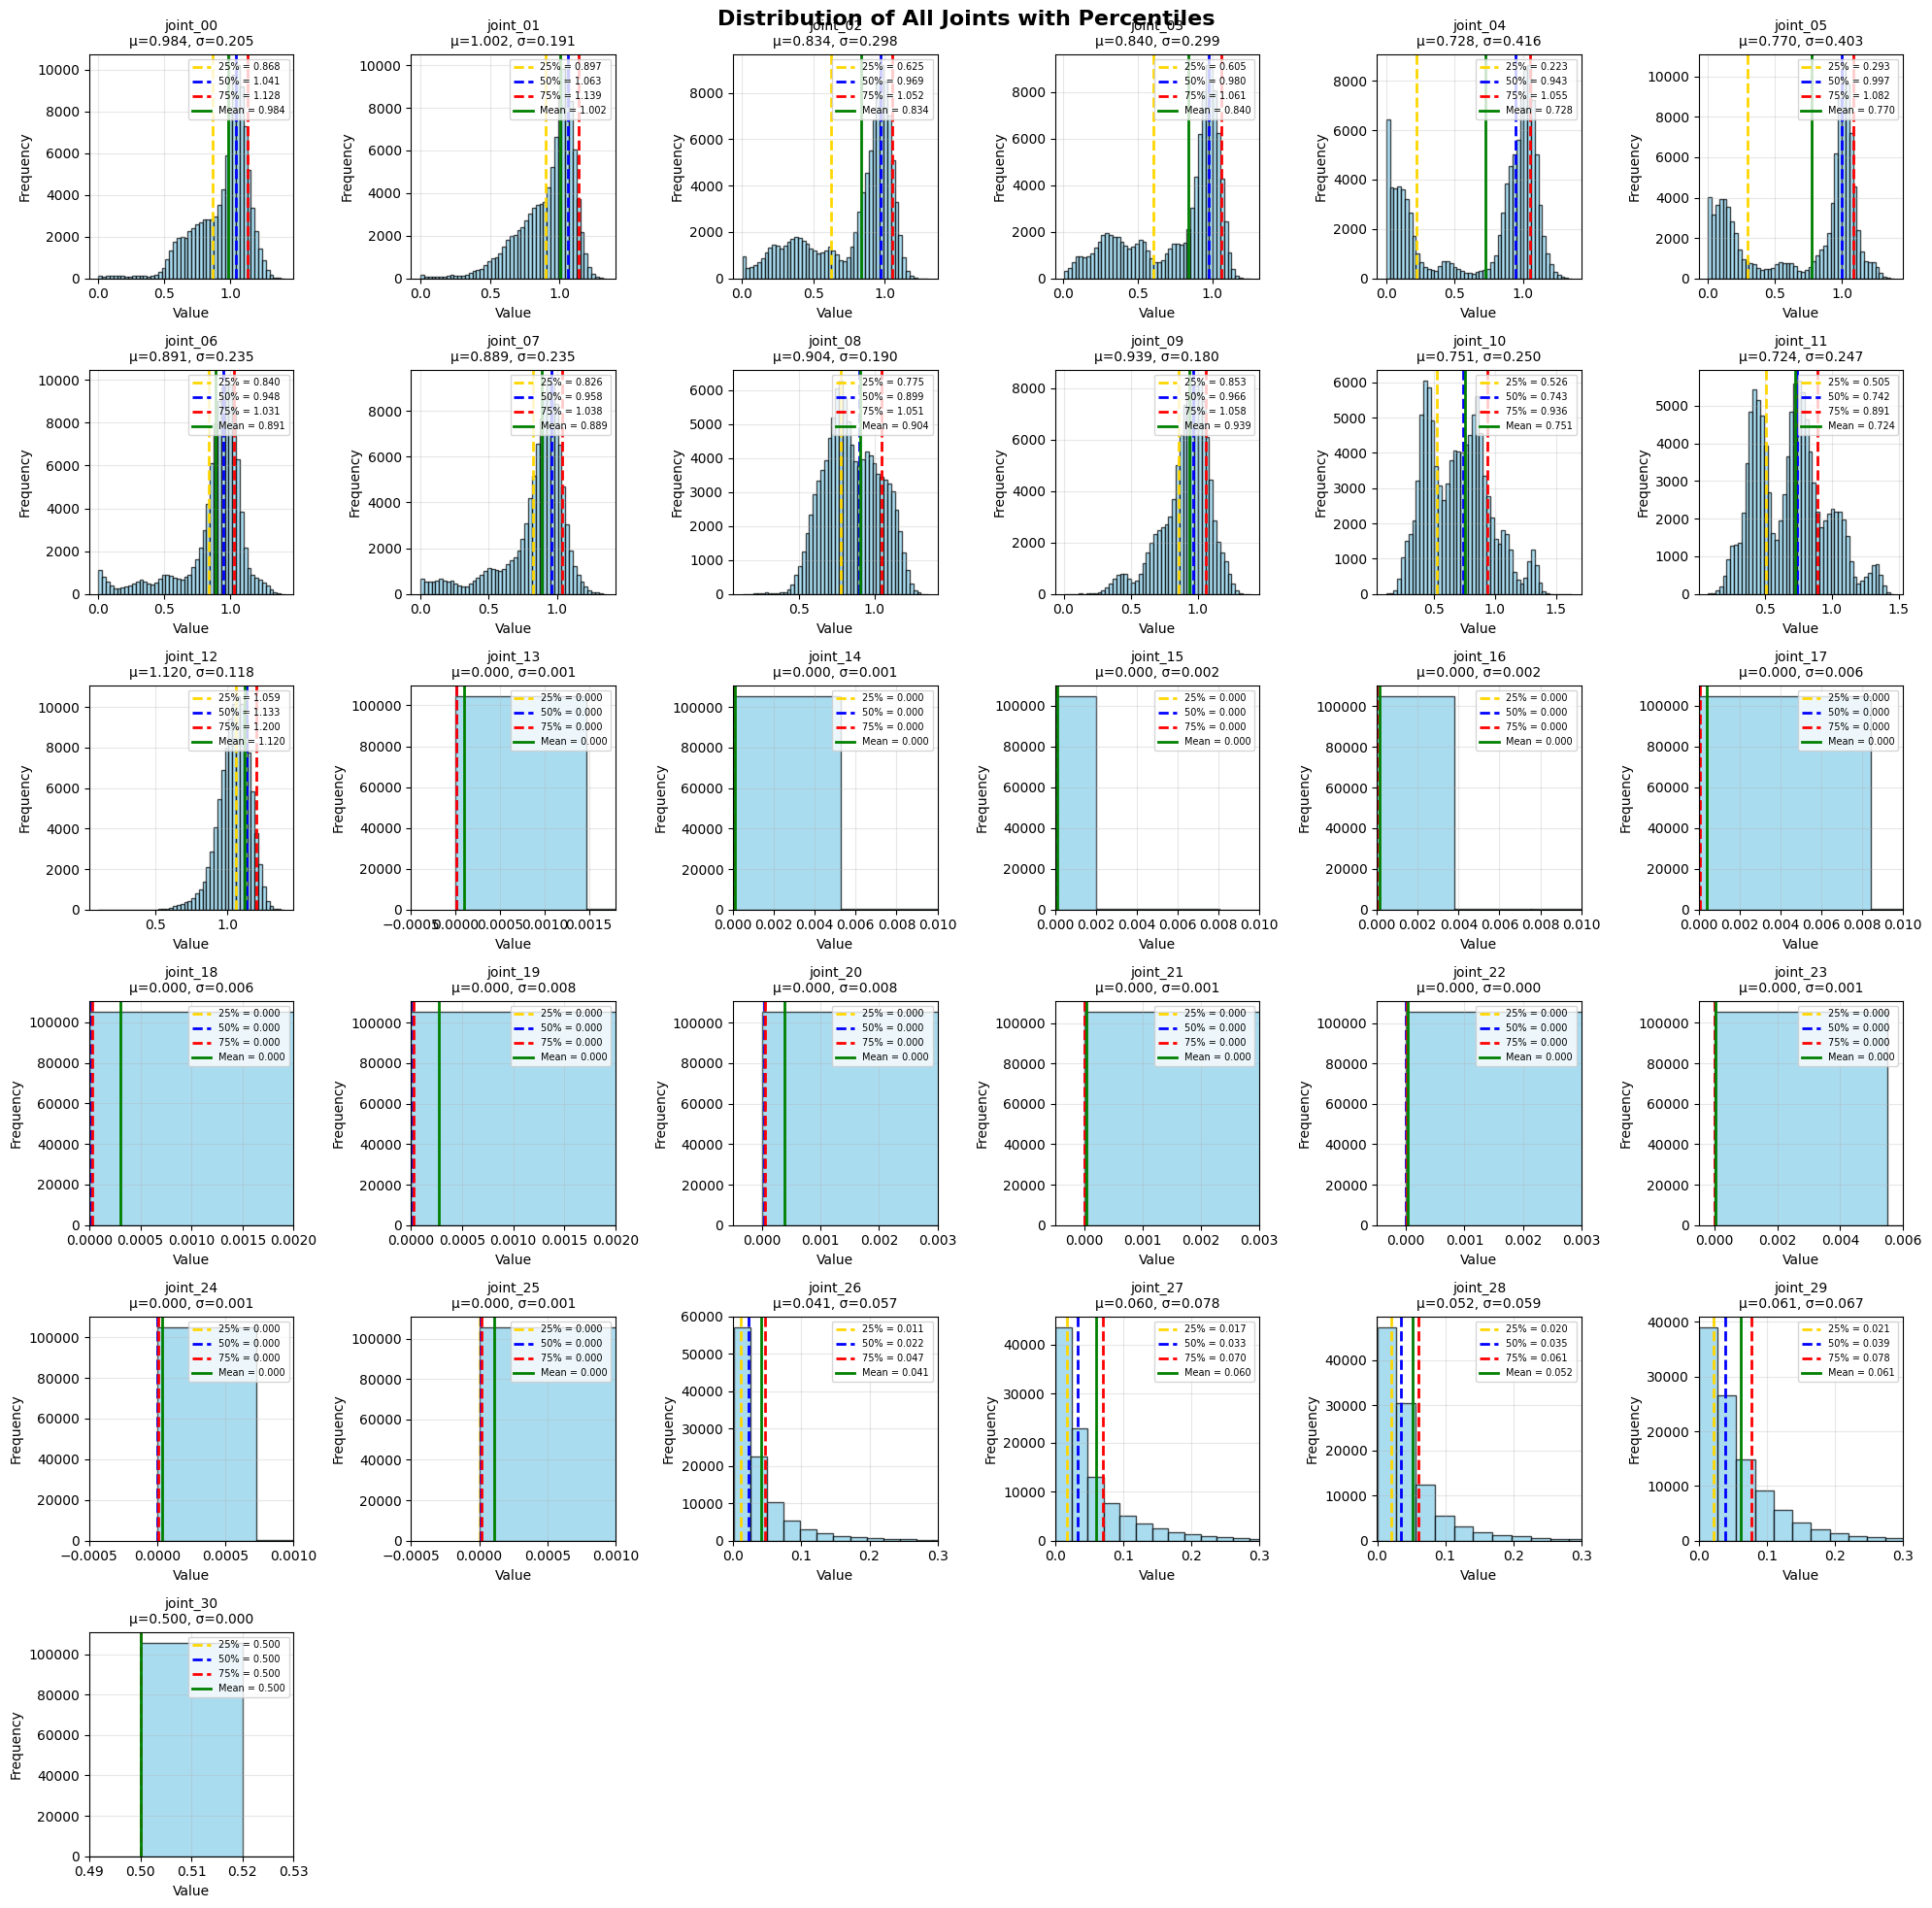


INSIGHTS FROM YOUR DATA

Total number of measurements: 105,760
Number of joints analyzed: 31

Most variable joints (highest std):
  joint_04: σ = 0.4161
  joint_05: σ = 0.4030
  joint_03: σ = 0.2986
  joint_02: σ = 0.2985
  joint_10: σ = 0.2500

Least variable joints (lowest std):
  joint_14: σ = 0.0011
  joint_24: σ = 0.0006
  joint_23: σ = 0.0006
  joint_22: σ = 0.0004
  joint_30: σ = 0.0000

Joints with potential outliers (max > mean + 3σ):
  joint_10: max=1.5126 is 3.05σ above mean
  joint_11: max=1.5010 is 3.15σ above mean
  joint_12: max=1.5003 is 3.23σ above mean
  joint_13: max=0.1701 is 134.97σ above mean
  joint_14: max=0.1255 is 112.02σ above mean
  joint_15: max=0.3148 is 172.27σ above mean
  joint_16: max=0.3325 is 186.62σ above mean
  joint_17: max=0.5276 is 93.42σ above mean
  joint_18: max=1.5103 is 274.37σ above mean
  joint_19: max=1.5531 is 203.15σ above mean
  joint_20: max=1.4378 is 182.86σ above mean
  joint_21: max=0.3899 is 266.23σ above mean
  joint_22: max=0.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate statistics for all joints
stats = df_features_raw[joint_cols].describe()
# stats = df_test_raw[joint_cols].describe()

# Function to plot distribution for a single joint
def plot_joint_distribution(joint_name, data, ax):
    """
    Plot histogram with percentile lines for a single joint
    """
    # Get statistics for this joint
    mean_val = stats[joint_name]['mean']
    std_val = stats[joint_name]['std']
    p25 = stats[joint_name]['25%']
    p50 = stats[joint_name]['50%']
    p75 = stats[joint_name]['75%']
    min_val = stats[joint_name]['min']
    max_val = stats[joint_name]['max']

    # Create histogram
    n, bins, patches = ax.hist(data[joint_name].dropna(), bins=50,
                                color='skyblue', edgecolor='black', alpha=0.7)

    # Add vertical lines for percentiles
    ax.axvline(p25, color='gold', linestyle='--', linewidth=2, label=f'25% = {p25:.3f}')
    ax.axvline(p50, color='blue', linestyle='--', linewidth=2, label=f'50% = {p50:.3f}')
    ax.axvline(p75, color='red', linestyle='--', linewidth=2, label=f'75% = {p75:.3f}')
    ax.axvline(mean_val, color='green', linestyle='-', linewidth=2, label=f'Mean = {mean_val:.3f}')

    # Set x-axis limits based on joint number
    joint_num = int(joint_name.split('_')[1])
    # Custom x-axis limits for specific joint ranges
    if 26 <= joint_num <= 29:
        ax.set_xlim(-0.0005, 0.3)
    elif joint_num == 13:
        ax.set_xlim(-0.0005, 0.0018)
    elif 14 <= joint_num <= 17:
        ax.set_xlim(0.0, 0.01)
    elif 18 <= joint_num <= 19:
        ax.set_xlim(0.0, 0.002)
    elif 20 <= joint_num <= 22:
        ax.set_xlim(-0.0005, 0.003)
    elif joint_num == 23:
        ax.set_xlim(-0.0005, 0.006)
    elif 24 <= joint_num <= 25:
        ax.set_xlim(-0.0005, 0.001)
    elif joint_num == 30:
        ax.set_xlim(0.49, 0.53)

    # For all other joints, no limit (let matplotlib decide)


    # Add labels and title
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{joint_name}\nμ={mean_val:.3f}, σ={std_val:.3f}', fontsize=10)
    ax.legend(fontsize=7, loc='upper right')
    ax.grid(True, alpha=0.3)

# Create a grid of subplots - 6 rows x 6 columns (31 joints + 5 empty)
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
fig.suptitle('Distribution of All Joints with Percentiles', fontsize=16, fontweight='bold')

# Flatten axes array for easy iteration
axes_flat = axes.flatten()

# Plot each joint
for idx, joint in enumerate(joint_cols):
    plot_joint_distribution(joint, df_features_raw, axes_flat[idx])

# Hide unused subplots
for idx in range(len(joint_cols), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.show()


# ============================================
# Summary table with interesting insights
# ============================================

print("\n" + "="*80)
print("INSIGHTS FROM YOUR DATA")
print("="*80)

print(f"\nTotal number of measurements: {len(df_features_raw):,}")
print(f"Number of joints analyzed: {len(joint_cols)}")

# Find joints with highest/lowest variability
joint_variability = stats.loc['std'].sort_values(ascending=False)
print(f"\nMost variable joints (highest std):")
for joint in joint_variability.head(5).index:
    print(f"  {joint}: σ = {joint_variability[joint]:.4f}")

print(f"\nLeast variable joints (lowest std):")
for joint in joint_variability.tail(5).index:
    print(f"  {joint}: σ = {joint_variability[joint]:.4f}")

# Check for potential outliers (values beyond 3 standard deviations)
print(f"\nJoints with potential outliers (max > mean + 3σ):")
for joint in joint_cols:
    mean_val = stats[joint]['mean']
    std_val = stats[joint]['std']
    max_val = stats[joint]['max']

    if max_val > mean_val + 3 * std_val:
        print(f"  {joint}: max={max_val:.4f} is {(max_val - mean_val) / std_val:.2f}σ above mean")

# Check skewness (comparing mean vs median)
print(f"\nSkewness check (mean vs median):")
skewed_joints = []
for joint in joint_cols:
    mean_val = stats[joint]['mean']
    median_val = stats[joint]['50%']
    diff = abs(mean_val - median_val)

    if diff > 0.1:  # Significant difference
        skewed_joints.append((joint, mean_val, median_val, diff))

skewed_joints.sort(key=lambda x: x[3], reverse=True)
for joint, mean_val, median_val, diff in skewed_joints[:5]:
    if mean_val > median_val:
        print(f"  {joint}: Right-skewed (mean {mean_val:.3f} > median {median_val:.3f}, diff={diff:.3f})")
    else:
        print(f"  {joint}: Left-skewed (mean {mean_val:.3f} < median {median_val:.3f}, diff={diff:.3f})")

print("="*80)

**______ Analisys Summary:**

In most of these plots, the Mean (green dashed line) is clearly separate from the Median (red dashed line, 50th percentile), confirming they are not Normal distributions.

*From joint_13 to joint_25* we have **Uniform Distribution**: mean = 0.0 and std = 0.006(maximum).

*From joint_26 to joint_29* we have **Exponential distributions**.

It seems the *joint_30*   feature is constant (mean =0.5) but std = 0.0

**Multimodal Distributions**
Several of the plots, particularly joint_04, joint_05, joint_10, and joint_11, show clear evidence of multimodality.

Multimodal: A distribution with two or more distinct peaks (or modes).

What it suggests: This often indicates that the data for that joint comes from two or more underlying groups or states. For example, a joint might have one set of common positions (one peak) and another set of common positions (the second peak), with fewer values in between.

**Skewed Distributions**
Other plots, like joint_01 and joint_07, show clear signs of skewness (asymmetry).

Left (Negative) Skew: The tail on the left side (lower values) is longer. (like joint_01).

Right (Positive) Skew: The tail on the right side (higher values) is longer.

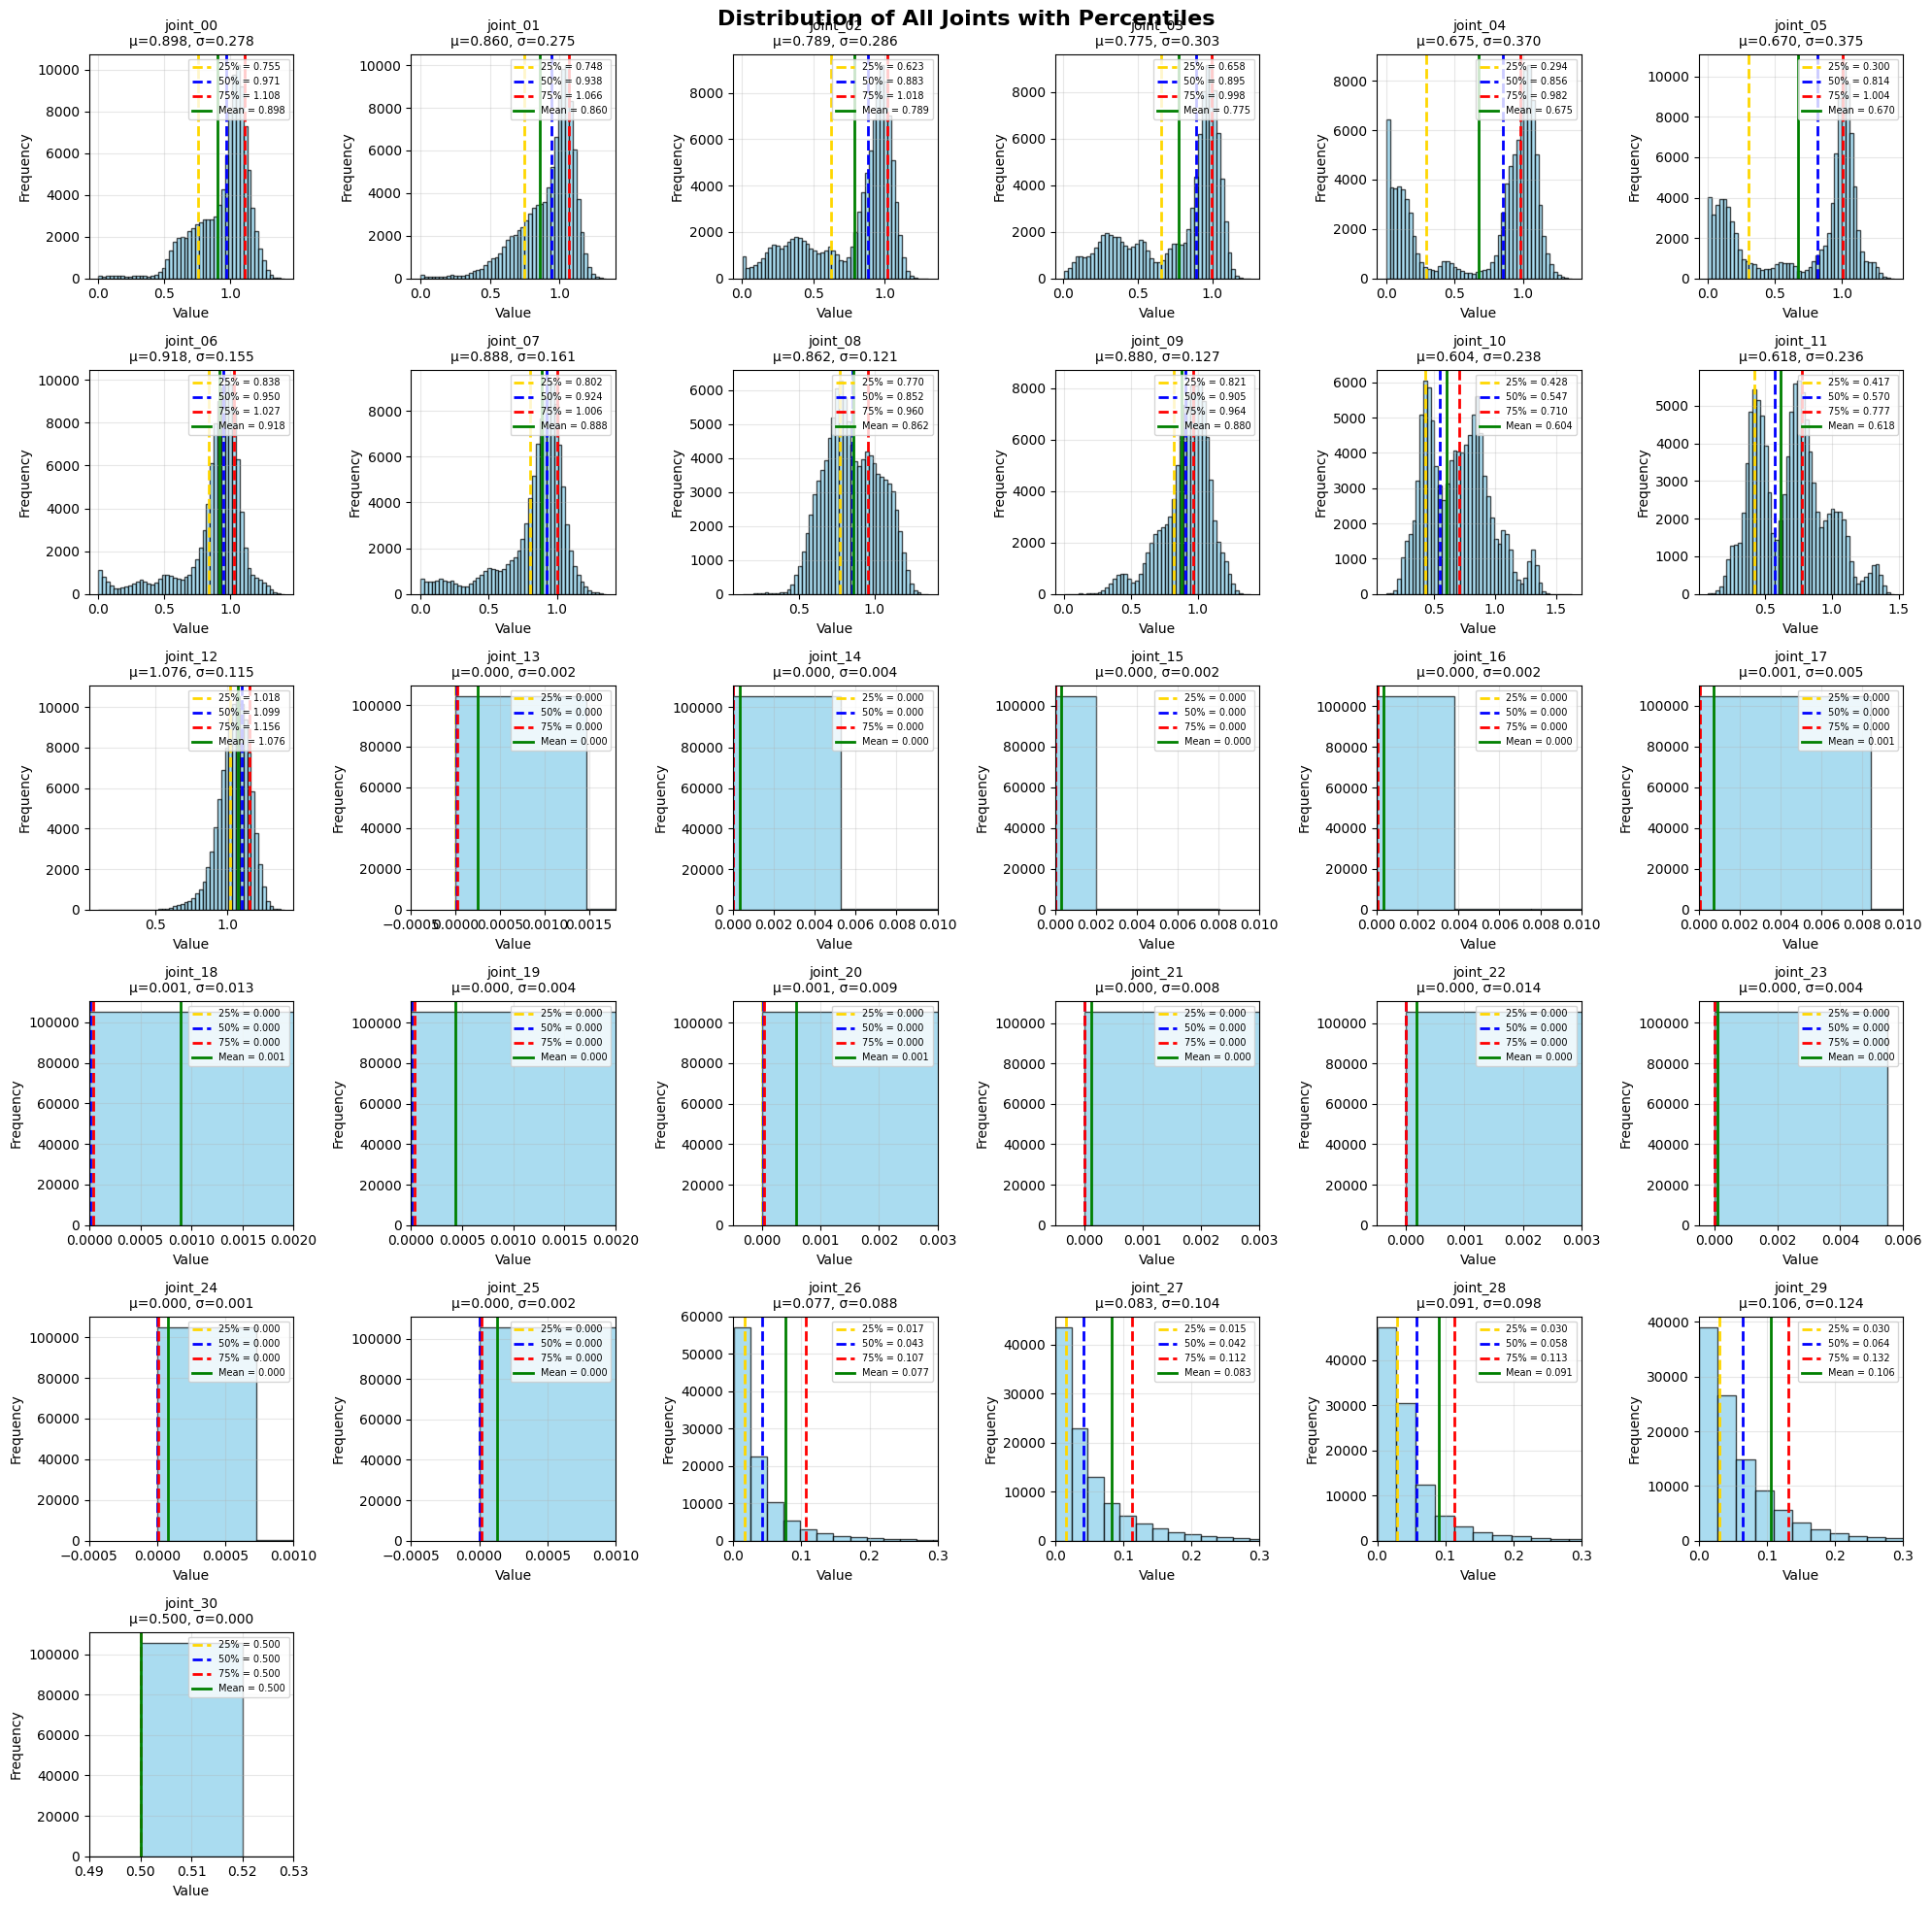

In [28]:
df_features_x_labels = pd.merge(df_features_raw, df_labels_raw, on='sample_index', how='left')

# label's column is named 'label'
df_no_pain = df_features_x_labels[df_features_x_labels['label'] == 'no_pain'].copy()
df_low_pain = df_features_x_labels[df_features_x_labels['label'] == 'low_pain'].copy()
df_high_pain = df_features_x_labels[df_features_x_labels['label'] == 'high_pain'].copy()
#_____________________________________________
stats = df_high_pain[joint_cols].describe()
#_____________________________________________

# Function to plot distribution for a single joint
def plot_joint_distribution(joint_name, data, ax):
    """
    Plot histogram with percentile lines for a single joint
    """
    # Get statistics for this joint
    mean_val = stats[joint_name]['mean']
    std_val = stats[joint_name]['std']
    p25 = stats[joint_name]['25%']
    p50 = stats[joint_name]['50%']
    p75 = stats[joint_name]['75%']
    min_val = stats[joint_name]['min']
    max_val = stats[joint_name]['max']

    # Create histogram
    n, bins, patches = ax.hist(data[joint_name].dropna(), bins=50,
                                color='skyblue', edgecolor='black', alpha=0.7)

    # Add vertical lines for percentiles
    ax.axvline(p25, color='gold', linestyle='--', linewidth=2, label=f'25% = {p25:.3f}')
    ax.axvline(p50, color='blue', linestyle='--', linewidth=2, label=f'50% = {p50:.3f}')
    ax.axvline(p75, color='red', linestyle='--', linewidth=2, label=f'75% = {p75:.3f}')
    ax.axvline(mean_val, color='green', linestyle='-', linewidth=2, label=f'Mean = {mean_val:.3f}')

    # Set x-axis limits based on joint number
    joint_num = int(joint_name.split('_')[1])
    # Custom x-axis limits for specific joint ranges
    if 26 <= joint_num <= 29:
        ax.set_xlim(-0.0005, 0.3)
    elif joint_num == 13:
        ax.set_xlim(-0.0005, 0.0018)
    elif 14 <= joint_num <= 17:
        ax.set_xlim(0.0, 0.01)
    elif 18 <= joint_num <= 19:
        ax.set_xlim(0.0, 0.002)
    elif 20 <= joint_num <= 22:
        ax.set_xlim(-0.0005, 0.003)
    elif joint_num == 23:
        ax.set_xlim(-0.0005, 0.006)
    elif 24 <= joint_num <= 25:
        ax.set_xlim(-0.0005, 0.001)
    elif joint_num == 30:
        ax.set_xlim(0.49, 0.53)

    # For all other joints, no limit (let matplotlib decide)


    # Add labels and title
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{joint_name}\nμ={mean_val:.3f}, σ={std_val:.3f}', fontsize=10)
    ax.legend(fontsize=7, loc='upper right')
    ax.grid(True, alpha=0.3)

# Create a grid of subplots - 6 rows x 6 columns (31 joints + 5 empty)
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
fig.suptitle('Distribution of All Joints with Percentiles', fontsize=16, fontweight='bold')

# Flatten axes array for easy iteration
axes_flat = axes.flatten()

# Plot each joint
for idx, joint in enumerate(joint_cols):
    plot_joint_distribution(joint, df_features_raw, axes_flat[idx])

# Hide unused subplots
for idx in range(len(joint_cols), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.show()


print("="*80)

LOW PAIN respect to general case (all labels)

Joint 01-02-04 has higher variance and a 25% quantile moved on the right.
Joint 26-27-29 has higher variance and very different mean, expecially joint 27.

HIGH PAIN respect to general case (all labels)

From Joint 26 to 29 the mean and variance are higher

**Correlation between missing body parts**


It seems if one is missing, all are missing: they could be preprocessed into one single feature.

In [ ]:
def plot_categorical_distributions(df, cols, palette, filename):
    """Plots count distributions for a list of categorical columns and prints frequencies."""
    n_cols = len(cols)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

    # Ensure axes is an array even if there's only one column
    if n_cols == 1:
        axes = [axes]

    freq_dfs = []
    for i, col in enumerate(cols):
        # Prepare frequencies to be displayed
        freq_df = df[col].value_counts().sort_index().reset_index()
        freq_df.columns = [col, 'count']
        freq_dfs.append(freq_df)

        # Plot distributions
        sns.countplot(
            x=col,
            data=df,
            palette=palette,
            order=df[col].value_counts().sort_index().index,
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('count')

    # Display frequencies side by side
    display(pd.concat(freq_dfs, axis=1))

    plt.tight_layout()
    plt.savefig(filename)
    print(f"\nSaved {filename} plot to: '{filename}'")
    plt.show()

# Display summary for categorical features
print("\nDescriptive statistics summary (categorical features)")
plot_categorical_distributions(df_features_x_labels, pain_survey_cols, "viridis", "pain_survey_distributions.png")
plot_categorical_distributions(df_features_x_labels.groupby('sample_index')[body_parts_cols].head(1), body_parts_cols, "viridis", "body_parts_distributions.png")

STUDIO PIRATES


In [31]:
# 1️⃣ Filter rows where n_legs == 'one+peg_leg'
df_filtered = df_features_x_labels[df_features_x_labels['n_legs'] == 'one+peg_leg'].copy()

# 2️⃣ Get the unique sample_index values that meet the condition
sample_indices = df_filtered['sample_index'].unique()

# 3️⃣ Get the labels corresponding to those sample indices
labels_for_filtered = (
    df_features_x_labels[['sample_index', 'label']]
    .drop_duplicates(subset='sample_index')
    .query('sample_index in @sample_indices')
)

# 4️⃣ (Optional) print or inspect them
print(labels_for_filtered)


       sample_index     label
1280              8   no_pain
21920           137   no_pain
34560           216   no_pain
54080           338  low_pain
56000           350   no_pain
79360           496   no_pain


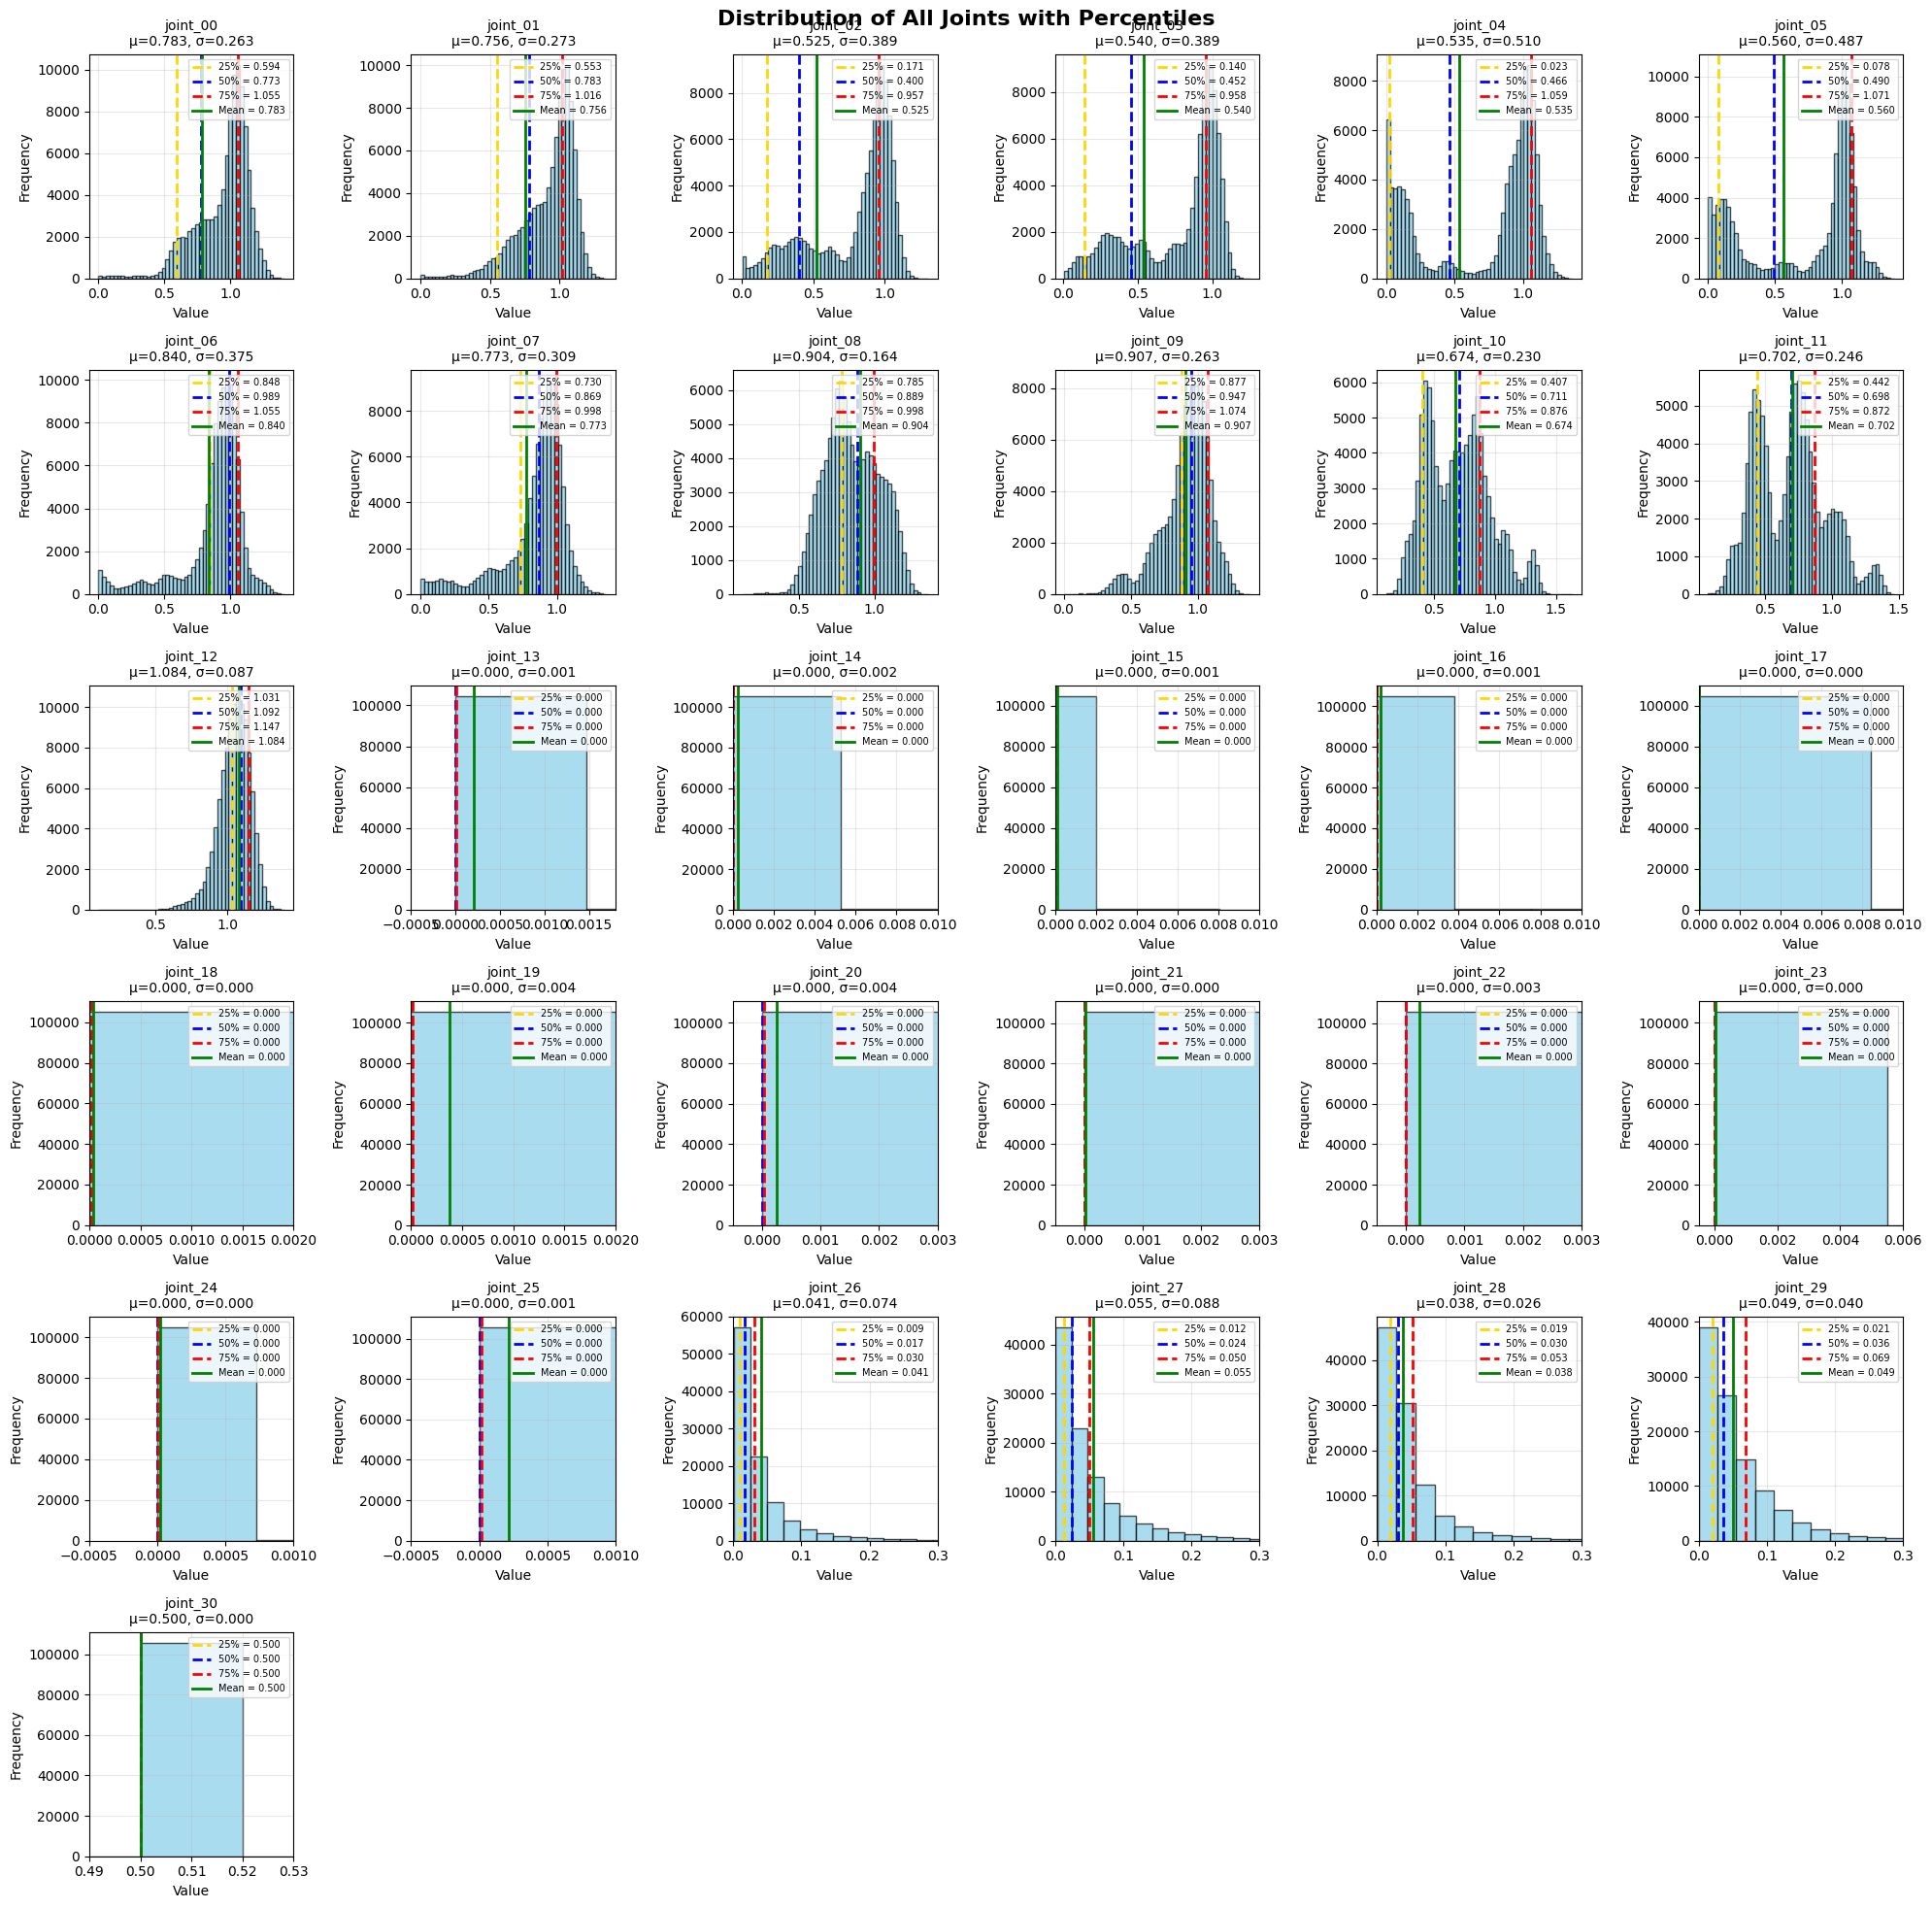

In [32]:


stats = df_filtered[joint_cols].describe()

# Function to plot distribution for a single joint
def plot_joint_distribution(joint_name, data, ax):
    """
    Plot histogram with percentile lines for a single joint
    """
    # Get statistics for this joint
    mean_val = stats[joint_name]['mean']
    std_val = stats[joint_name]['std']
    p25 = stats[joint_name]['25%']
    p50 = stats[joint_name]['50%']
    p75 = stats[joint_name]['75%']
    min_val = stats[joint_name]['min']
    max_val = stats[joint_name]['max']

    # Create histogram
    n, bins, patches = ax.hist(data[joint_name].dropna(), bins=50,
                                color='skyblue', edgecolor='black', alpha=0.7)

    # Add vertical lines for percentiles
    ax.axvline(p25, color='gold', linestyle='--', linewidth=2, label=f'25% = {p25:.3f}')
    ax.axvline(p50, color='blue', linestyle='--', linewidth=2, label=f'50% = {p50:.3f}')
    ax.axvline(p75, color='red', linestyle='--', linewidth=2, label=f'75% = {p75:.3f}')
    ax.axvline(mean_val, color='green', linestyle='-', linewidth=2, label=f'Mean = {mean_val:.3f}')

    # Set x-axis limits based on joint number
    joint_num = int(joint_name.split('_')[1])
    # Custom x-axis limits for specific joint ranges
    if 26 <= joint_num <= 29:
        ax.set_xlim(-0.0005, 0.3)
    elif joint_num == 13:
        ax.set_xlim(-0.0005, 0.0018)
    elif 14 <= joint_num <= 17:
        ax.set_xlim(0.0, 0.01)
    elif 18 <= joint_num <= 19:
        ax.set_xlim(0.0, 0.002)
    elif 20 <= joint_num <= 22:
        ax.set_xlim(-0.0005, 0.003)
    elif joint_num == 23:
        ax.set_xlim(-0.0005, 0.006)
    elif 24 <= joint_num <= 25:
        ax.set_xlim(-0.0005, 0.001)
    elif joint_num == 30:
        ax.set_xlim(0.49, 0.53)

    # For all other joints, no limit (let matplotlib decide)


    # Add labels and title
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{joint_name}\nμ={mean_val:.3f}, σ={std_val:.3f}', fontsize=10)
    ax.legend(fontsize=7, loc='upper right')
    ax.grid(True, alpha=0.3)

# Create a grid of subplots - 6 rows x 6 columns (31 joints + 5 empty)
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
fig.suptitle('Distribution of All Joints with Percentiles', fontsize=16, fontweight='bold')

# Flatten axes array for easy iteration
axes_flat = axes.flatten()

# Plot each joint
for idx, joint in enumerate(joint_cols):
    plot_joint_distribution(joint, df_features_raw, axes_flat[idx])

# Hide unused subplots
for idx in range(len(joint_cols), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.show()


print("="*80)

ALL PIRATES, from joint 00 to 05 has lower mean and higher variance. All, except one, has no_pain label in the training set.

_______________________________________________________
Analise correlation between pain_survey and labels

In [42]:
df_features_x_labels = pd.merge(df_features_raw, df_labels_raw, on='sample_index', how='left')
df_selected = df_features_x_labels[['sample_index', 'time', 'label'] + pain_survey_cols].copy()

df_no_pain  = df_selected[df_selected['label'] == 'no_pain'].copy()
df_low_pain = df_selected[df_selected['label'] == 'low_pain'].copy()
df_high_pain = df_selected[df_selected['label'] == 'high_pain'].copy()



In [66]:
print(df_high_pain['sample_index'].unique())

[ 37  43  55  61  64  80  86  88  92 100 105 107 113 123 146 164 172 180
 204 208 234 240 248 252 275 280 286 287 300 332 343 366 376 382 386 387
 404 409 411 416 437 445 451 464 468 505 518 555 563 568 576 613 618 627
 635 645]


In [77]:
df_single_high_pain = df_high_pain[df_high_pain['sample_index'] == 645].copy()

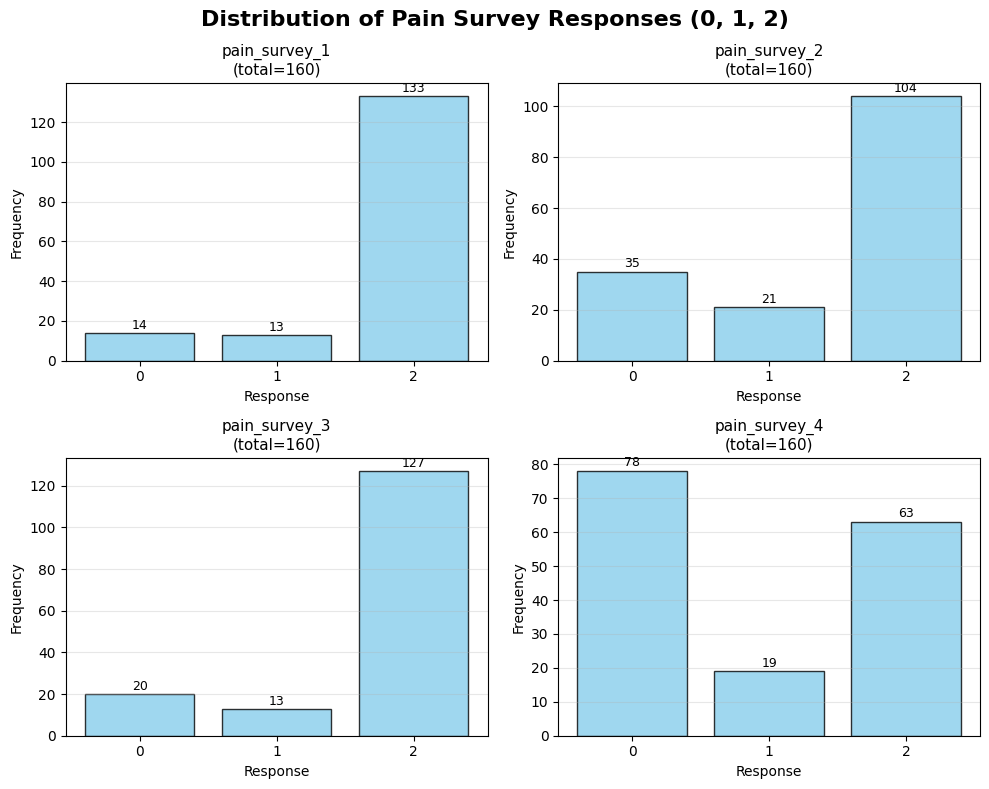

In [78]:
def plot_pain_distribution_discrete(col, data, ax):
    counts = data[col].value_counts().reindex([0, 1, 2], fill_value=0)
    # Bar plot
    ax.bar(counts.index, counts.values, color='skyblue', edgecolor='black', alpha=0.8)
    # Labels and title
    total = counts.sum()
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Response')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{col}\n(total={total})', fontsize=11)
    ax.grid(True, axis='y', alpha=0.3)
    # Annotate counts on top of bars
    for x, y in zip(counts.index, counts.values):
        ax.text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=9)

# ---- Plot all 4 pain surveys ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Distribution of Pain Survey Responses (0, 1, 2)', fontsize=16, fontweight='bold')
axes_flat = axes.flatten()

for i, col in enumerate(pain_survey_cols):
    plot_pain_distribution_discrete(col, df_single_high_pain, axes_flat[i])

plt.tight_layout()
plt.show()


LOW PAIN

Generally, the frequency has an increasing ‘stair-like’ shape.

low_pain outliners: 23, 384

HIGH PAIN

more 0s than 1, higer rario over 2s
high pain outliners: 37, 287, 613